<a href="https://colab.research.google.com/github/laventura/gen_models_examples/blob/main/VAE-with-interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 20)  # 10 for mean, 10 for log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        params = self.encoder(x)
        mu, logvar = params[:, :10], params[:, 10:]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [3]:
# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
# Training the VAE
vae = VAE(latent_dim=10)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [6]:
def train_vae(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()
            data = data.view(-1, 28*28)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}")


In [8]:
## Train the VAE
train_vae(vae, train_loader)

Epoch 1, Loss: 146.8939
Epoch 2, Loss: 120.6531
Epoch 3, Loss: 116.8297
Epoch 4, Loss: 114.8108
Epoch 5, Loss: 113.5476
Epoch 6, Loss: 112.5024
Epoch 7, Loss: 111.6819
Epoch 8, Loss: 111.0097
Epoch 9, Loss: 110.4500
Epoch 10, Loss: 109.9355


In [9]:
# Visualization: Original vs. Reconstructed Images
def plot_reconstructions(model, dataloader):
    model.eval()
    data, _ = next(iter(dataloader))
    data = data.view(-1, 28*28)
    with torch.no_grad():
        recon, _, _ = model(data)
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(data[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

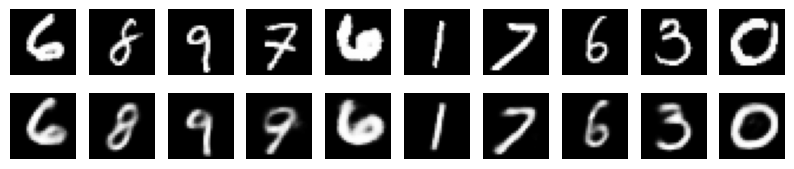

In [10]:
## Plot reconstruction
plot_reconstructions(vae, train_loader)

In [11]:
# Latent Space Interpolation
def interpolate(model, start, end, steps=10):
    model.eval()
    start, end = start.view(1, -1), end.view(1, -1)
    z = torch.cat([start + (end - start) * t / steps for t in range(steps)])
    with torch.no_grad():
        images = model.decoder(z).view(-1, 28, 28)
    fig, axes = plt.subplots(1, steps, figsize=(steps, 1))
    for i in range(steps):
        axes[i].imshow(images[i].cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()


In [12]:
# perform latent space interpolation
data, _ = next(iter(train_loader))
mu, _ = vae.encoder(data.view(-1, 28*28))[:, :10].chunk(2, dim=1)
interpolate(vae, mu[0], mu[1])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x5 and 10x400)

In [13]:
# Latent Space Interpolation
def interpolate_gemini(model, start, end, steps=10):
    model.eval()
    start, end = start.view(1, -1), end.view(1, -1)
    # Fix: Remove the chunk operation and use the full latent dimension
    #z = torch.cat([start + (end - start) * t / steps for t in range(steps)])
    # Instead, directly interpolate between start and end in the latent space
    z = torch.cat([start + (end - start) * t / steps for t in range(steps + 1)]) # Include 'end' in the interpolation
    with torch.no_grad():
        images = model.decoder(z).view(-1, 28, 28)
    fig, axes = plt.subplots(1, steps + 1, figsize=(steps + 1, 1)) # Add 1 to steps for plotting
    for i in range(steps + 1): # Add 1 to steps for plotting
        axes[i].imshow(images[i].cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [16]:
# Get a batch of data from the dataloader
data, _ = next(iter(train_loader))

# Encode the data to get the latent space representation (mu)
with torch.no_grad():
    encoded_data, mu, logvar = vae.encoder(data.view(-1, 28*28))

# Select two points in the latent space to interpolate between
start_index = 0  # Index of the first data point
end_index = 1    # Index of the second data point
start_latent = mu[start_index]  # Latent representation of the first data point
end_latent = mu[end_index]    # Latent representation of the second data point

# Interpolate between the two latent points using the modified interpolate function
interpolate_gemini(vae, start_latent, end_latent, steps=10)  # Generate 10 intermediate images

ValueError: too many values to unpack (expected 3)

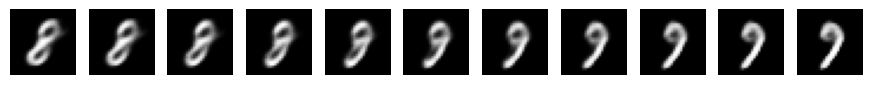

In [24]:
# Get a batch of data from the dataloader
data, _ = next(iter(train_loader))

# Encode the data to get the latent space representation (mu)
with torch.no_grad():
    # Get the encoded parameters
    encoded_params = vae.encoder(data.view(-1, 28*28))
    # Split the encoded parameters into mu and logvar
    mu, logvar = encoded_params[:, :vae.latent_dim], encoded_params[:, vae.latent_dim:]

# Select two points in the latent space to interpolate between
start_index = 0  # Index of the first data point
end_index = 1    # Index of the second data point
start_latent = mu[start_index]  # Latent representation of the first data point
end_latent = mu[end_index]    # Latent representation of the second data point

# Interpolate between the two latent points using the modified interpolate function
interpolate_gemini(vae, start_latent, end_latent, steps=10)  # Generate 10 intermediate images

In [25]:
# write a function to animate this interpolation
!pip install matplotlib
!pip install celluloid

In [26]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera

In [27]:
# animate the interpolation
def animate_interpolation(model, start, end, steps=10):
    """Animates the interpolation between two points in the latent space.

    Args:
        model: The trained VAE model.
        start: The starting point in the latent space.
        end: The ending point in the latent space.
        steps: The number of interpolation steps.
    """
    model.eval()
    start, end = start.view(1, -1), end.view(1, -1)
    z = torch.cat([start + (end - start) * t / steps for t in range(steps + 1)])
    with torch.no_grad():
        images = model.decoder(z).view(-1, 28, 28)

    fig = plt.figure()
    camera = Camera(fig)
    for i in range(steps + 1):
        plt.imshow(images[i].cpu().numpy(), cmap='gray')
        plt.title(f"Interpolation Step: {i}")
        camera.snap()

    animation_ = camera.animate()
    # Display the animation in the notebook
    return HTML(animation_.to_html5_video())

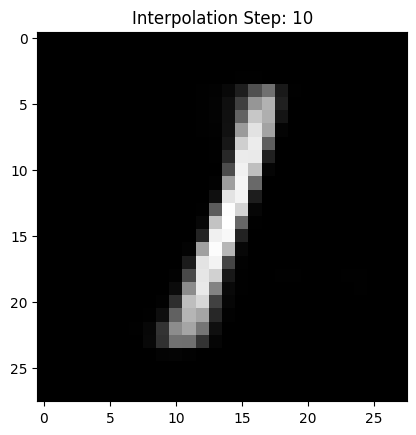

In [32]:
## now animate the interpolation between start and end latent vectors
# Get a batch of data from the dataloader
data, _ = next(iter(train_loader))

# Encode the data to get the latent space representation (mu)
with torch.no_grad():
    # Get the encoded parameters
    encoded_params = vae.encoder(data.view(-1, 28*28))
    # Split the encoded parameters into mu and logvar
    mu, logvar = encoded_params[:, :vae.latent_dim], encoded_params[:, vae.latent_dim:]

# Select two points in the latent space to interpolate between
start_index = 0  # Index of the first data point
end_index = 1    # Index of the second data point
start_latent = mu[start_index]  # Latent representation of the first data point
end_latent = mu[end_index]    # Latent representation of the second data point

# Animate the interpolation
animation = animate_interpolation(vae, start_latent, end_latent, steps=10)
display(animation)